In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
tr_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
ts_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv"

In [7]:
train_df = pd.read_csv(tr_path)
test_df = pd.read_csv(ts_path)

train_df = train_df.reindex(np.random.permutation(train_df.index))

In [8]:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean) / train_df_std

train_df_norm.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2614,0.948604,-0.737002,0.350415,-0.772342,-0.767286,-0.521473,-0.726156,-0.704595,-0.850989
2029,1.118166,-0.722966,1.383231,-0.612705,-0.624938,-0.743627,-0.668941,-0.364791,-1.063088
16387,-1.485110,1.092374,0.350415,-0.050306,-0.105364,-0.377726,-0.135810,0.222582,2.523630


In [9]:
test_df_norm = (test_df - train_df_mean) / train_df_std

test_df_norm.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.240741,0.816330,-0.126270,0.569434,0.288468,0.093589,0.272490,1.428039,1.184641
1,0.629428,-0.638749,1.144889,-0.520042,-0.544273,-0.540639,-0.583120,-0.149138,-0.265562
2,0.873797,-0.863328,-0.126270,0.433651,-0.076894,0.047416,-0.016181,1.000873,0.544896


In [10]:
threshold = 265000

train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] >
                                               threshold).astype(float)

test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] >
                                              threshold).astype(float)

In [43]:
features = ['median_income', 'total_rooms']

labels = ['median_house_value_is_high']

features_tensor = torch.tensor(train_df_norm.loc[:, features].values, dtype=torch.float32)

label_tensor = torch.tensor(train_df_norm[labels].values, dtype=torch.float32)

print(f"Shape of features tensor: {features_tensor.shape}")
print(f"Shape of label tensor: {label_tensor.shape}")

Shape of features tensor: torch.Size([17000, 2])
Shape of label tensor: torch.Size([17000, 1])


In [45]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=1),
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear_layer_stack(x)
        x = self.sigmoid(x)
        return x

In [109]:
def binary_accuracy(preds, y, threshold=0.5):
    rounded_preds = (preds > threshold).float()
    correct = (rounded_preds == y).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [149]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52

In [150]:
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

In [151]:
dataset = torch.utils.data.TensorDataset(features_tensor, label_tensor)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_list = []
accuracy_list = []
precision_list = []
recall_list = []

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for batch_feature, batch_label in dataloader:
        outputs = model(batch_feature)
        loss = criterion(outputs, batch_label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += binary_accuracy(outputs, batch_label)
        
        rounded_preds = (outputs > 0.5).float()
        true_positives += ((rounded_preds == 1) & (batch_label == 1)).sum().item()
        false_positives += ((rounded_preds == 1) & (batch_label == 0)).sum().item()
        false_negatives += ((rounded_preds == 0) & (batch_label == 1)).sum().item()
        
    
    precision = true_positives / (true_positives + false_positives + 1e-9)
    recall = true_positives / (true_positives + false_negatives + 1e-9)
    
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(epoch_accuracy / len(dataloader))
    loss_list.append(epoch_loss / len(dataloader))

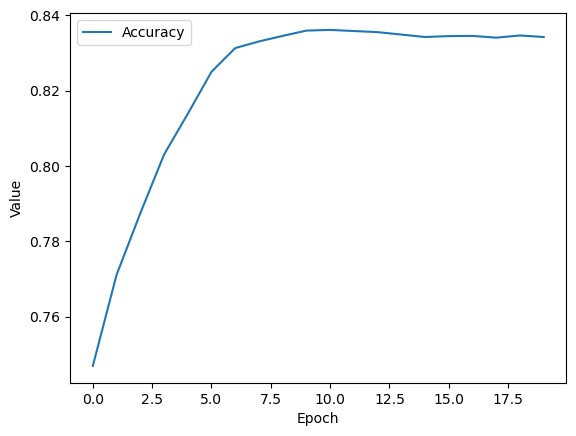

In [153]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.plot([accuracy.detach().numpy() for accuracy in accuracy_list], label='Accuracy')
plt.legend()
plt.show()

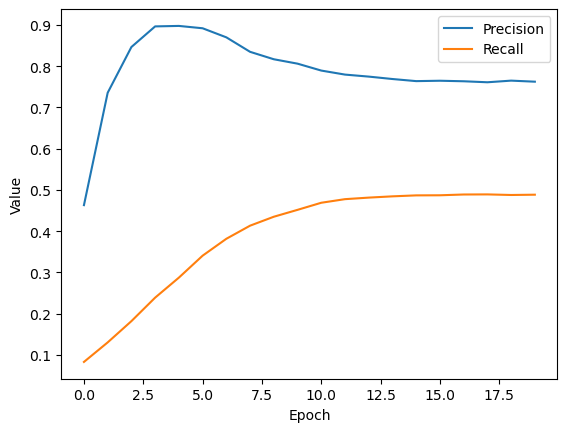

In [154]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.plot([precision for precision in precision_list], label='Precision')
plt.plot([recall for recall in recall_list], label='Recall')
plt.legend()
plt.show()

In [121]:
test_features_tensor = torch.tensor(test_df_norm.loc[:, features].values,
                                    dtype=torch.float32)

test_label_tensor = torch.tensor(test_df_norm[labels].values, dtype=torch.float32)

In [155]:
model.eval()
with torch.inference_mode():
    test_preds = model(test_features_tensor)
    test_loss = criterion(test_preds, test_label_tensor)
    test_acc = binary_accuracy(test_preds, test_label_tensor, classification_threshold)